In [1]:
from __future__ import division, print_function, absolute_import
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import sys
from PIL import Image
from timeit import time

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction.features import match_images

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.tools.plot_utils import draw_one_box as draw_box
from yolo3_deepsort.deep_sort.detection import Detection as ddet
import yolo3_deepsort.tools.box_filter as box_filter

Using TensorFlow backend.


# Create Components

In [2]:
# create yolov3 detector
score_thre = 0.4
iou_thre = 0.4
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/yolo_ori.h5',
            classes_path = 'yolo3_deepsort/model_data/coco_classes.txt',
            weights_only = True,
            score = score_thre,
            iou = iou_thre) # coco version
# yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
#             classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
#             weights_only = True,
#             score = 0.5,
#             iou = 0.5) # our version

# create feature encoder
model_filename = 'yolo3_deepsort/model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

# create tracker
max_distance = 0.3
lambda0 = 1# SORT
nn_budget = None
tracker = Tracker(metric_mode="cosine",max_cosine_distance=max_distance,
                      lambda0 = lambda0,nn_budget=nn_budget)

yolo3_deepsort/model_data/yolo_ori.h5 model, anchors, and classes loaded.


# Detection Tracking and Matching

In [8]:
import time
video_path = r"G:\binocular_video\20191022_022500_video.h265"
cap = cv2.VideoCapture(video_path)
w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(5)
thickness = 50

write_flag = False
if write_flag:
    out = cv2.VideoWriter('result/road_test_COCO2.avi',cv2.VideoWriter_fourcc(*'XVID'), fps, (w//2,2*h))
fontsize = 25

In [9]:
while cap.isOpened():
    toi = time.time()
    # read video
    ret,frame = cap.read()
    
    if ret != True:
        break# it's really really really important!!!
        
    frame_left = frame[:,:w//2,:]
    frame_right = frame[:,w//2:,:]
    img_left_pil = Image.fromarray(frame_left.copy()[...,::-1])
    img_right_pil = Image.fromarray(frame_right.copy()[...,::-1])
    
    # detection
    boxes,classes,scores = yolo.detect_image(img_left_pil)
    
    # filter boxes
    boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w_img,h_img))
    boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
    boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)

    # encoder features
    features = encoder(frame_left,boxes)
    detections = [Detection(bbox, score, feature,class_)
                    for bbox,score,feature,class_ in zip(boxes,scores,features,classes)]
    
    # call the tracker
    tracker.predict()
    tracker.update(detections)
    
#     print("fps:%f"%(1/(time.time()-toi)))
    
    # Visualize result++++++++++++++++++
    img_left_draw = img_left_pil.copy()
    img_right_draw = img_right_pil.copy()
    for i,track in enumerate(tracker.tracks):
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        
        # track.to_tlbr() actually get ltrb && track.to_tlwh() actually get ltwh 
        bbox = track.to_tlbr()
        _,_,bbox_matched = match_images(frame_left,frame_right,track.to_tlwh().astype(int),
                                        offset=(-400,-40,0,40),method = cv2.TM_CCOEFF_NORMED)# match two image
        
        # property of the object
        object_id = track.track_id
        object_class = track.object_class
        color = yolo.colors[yolo.class_names.index(object_class)]
        # draw boxes
        img_left_draw = draw_box(img_left_draw,bbox,object_id,object_class,color,fontsize)
        img_right_draw = draw_box(img_right_draw,bbox_matched,object_id,object_class,color,fontsize)
        
    img_left_show = np.asarray(img_left_draw)
    img_right_show = np.asarray(img_right_draw)
    img_show = np.concatenate((img_left_show,img_right_show),axis = 0)
    
    if write_flag:
        out.write(img_show[...,::-1])# save result
    cv2.imshow('demo',cv2.resize(img_show[...,::-1],(int(w/2.5),int(h/1.5))))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
if write_flag:
    out.release()
cap.release()
cv2.destroyAllWindows()

# 3D reconstruct

In [3]:
# Read Parameters

intrinsic_path = r'G:\binocular_video\stereo_intrinsic.yml'
extrinsic_path = r'G:\binocular_video\stereo_extrinsic.yml'
intrinsic_paras = cv2.FileStorage(intrinsic_path, cv2.FILE_STORAGE_READ)
extrinsic_paras = cv2.FileStorage(extrinsic_path, cv2.FILE_STORAGE_READ)
P1 = extrinsic_paras.getNode('P1').mat()
P2 = extrinsic_paras.getNode('P2').mat()
R1 = extrinsic_paras.getNode('R1').mat()
R2 = extrinsic_paras.getNode('R2').mat()
T1 = np.zeros((3,1))
T2 = extrinsic_paras.getNode('T').mat()
M1 = intrinsic_paras.getNode('M1').mat()
M2 = intrinsic_paras.getNode('M2').mat()
D1 = intrinsic_paras.getNode('D1').mat()
D2 = intrinsic_paras.getNode('D2').mat()
# print(P1)
# print(np.dot(M1,np.hstack((R1,T1))))
# print(P2)
# print(np.dot(M2,np.hstack((R2,T2))))

In [4]:
# Read Images

img_left = cv2.imread(r'G:\binocular_video\img\3400_left.jpg')
img_right = cv2.imread(r'G:\binocular_video\img\3400_right.jpg')

img_left_pil = Image.fromarray(img_left.copy()[...,::-1])
img_right_pil = Image.fromarray(img_right.copy()[...,::-1])

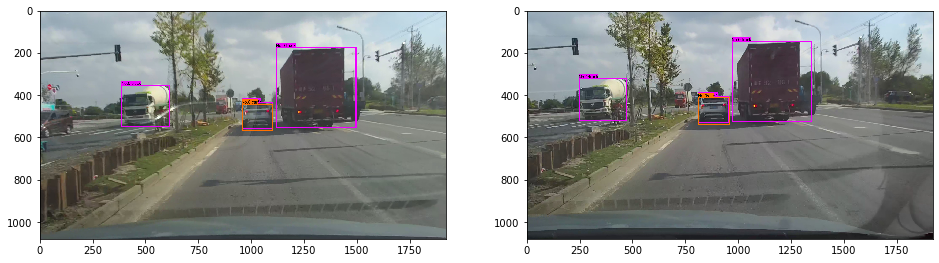

In [9]:
# Detection and Matching

COI = ['person','bicycle','car','motorcycle','bus','train','truck']
h_img,w_img,_ = img_left.shape
thickness = 150
boxes,classes,scores = yolo.detect_image(img_left_pil)# detect object

# filter boxes
boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w_img,h_img))
boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)

# NMS
# idx2 = box_filter.non_max_suppression_idx(boxes,0.5,scores)
# boxes, classes, scores = box_filter.get_by_index(idx2,boxes, classes, scores)

boxes_matched = []
boxes = np.array(boxes)# easier to compute
img_left_draw = img_left_pil.copy()
img_right_draw = img_right_pil.copy()
for i,box in enumerate(boxes):
    ret,search_patch,box_matched = match_images(img_left,img_right,box,offset=(-400,-40,0,40),
                                   method = cv2.TM_CCOEFF_NORMED)# match two image
    boxes_matched.append(box_matched)
#     search_patches.append(search_patch)
#     rets.append(ret)
    
    object_id = '0'
    object_class = classes[i]
    color = yolo.colors[yolo.class_names.index(object_class)]
    # draw boxes
    box[2:] = box[2:] + box[:2]# ltwh 2 ltrb. Note boxes had been changed!!!!!
    img_left_draw = draw_box(img_left_draw,box,object_id,object_class,color,20)
    img_right_draw = draw_box(img_right_draw,box_matched,object_id,object_class,color,20)
#     print("box_r",box_matched)
    
boxes_matched = np.array(boxes_matched)

img_left_show = np.asarray(img_left_draw)
img_right_show = np.asarray(img_right_draw)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img_left_show)
plt.subplot(122)
plt.imshow(img_right_show)

cv2.imshow('left',img_left_show[...,::-1])
cv2.imshow('right',img_right_show[...,::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

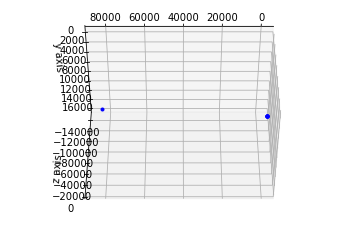

distance:
[   226.0556787     252.96657577 175691.31963296    255.51118535
    224.63179783    259.27144498    241.35607483]


In [29]:
# use the center of boxes stand for object's location
pts2D_1 = np.ones((3,len(boxes)),dtype='float')
pts2D_2 = np.ones((3,len(boxes)),dtype='float')

# boxes[:,2:] = boxes[:,2:] + boxes[:,:2]# ltwh 2 ltrb
for i in range(len(boxes)):
    pts2D_1[:2,i] = (boxes[i,:2] + boxes[i,2:])/2.
    pts2D_2[:2,i] = (boxes_matched[i,:2] + boxes_matched[i,2:])/2.

# triangulation
pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P1,P2)
# pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P2,P1)
# X朝右，Y朝上，Z朝前
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pts3D[0], pts3D[1], pts3D[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()
# print('2D1:')
# print(pts2D_1)
# print("2D2:")
# print(pts2D_2)
# print(pts3D[:3,:])
print("distance:")
print(np.sqrt(np.sum(pts3D[:3,:]**2,axis=0)))

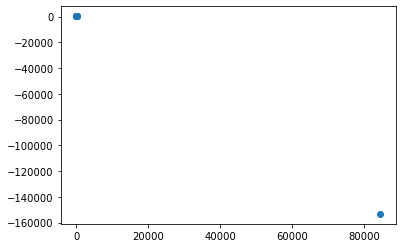

In [30]:
# 俯视图
plt.scatter(pts3D[0,:],pts3D[2,:])